In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [2]:
import os
from IPython.display import Image, display
os.chdir('/content/drive/MyDrive/Conecta_4_proyecto')

#Equipo 3: Intro to Game AI

Conecta 4 es un juego para dos jugadores en donde se sueltan fichas a lo largo de un tablero vertical con el objetivo de alinear 4 fichas del mismo color.

In [9]:
Image(filename='./imagenes/conecta_4.png', width=420)

Output hidden; open in https://colab.research.google.com to view.

Nuestro objetivo es utilizar el aprendizaje por refuerzo (RL) para entrenar una IA que sea capaz de jugar y formar estrategias a través del juego sucesivo para así maximizar su posibilidad de victoria.

Para empezar debemos definir el entorno de juego y los agentes. En nuestro caso utilizaremos el entorno ConnectX el cual ya cuenta con todo el marco de juego: tablero, reglas, agentes, etc. Para instalarlo usaremos la paquetería de python de kaggle-environments.

In [10]:
!pip install "kaggle-environments>=0.1.6"

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of shimmy to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 14.0 MB/s eta 0:00:00
  Created wheel for Chessnut: filename=Chessnut-0.3.1-py3-none-any.whl size=10034 sha256=1848da119020c55d9a98b6d36e5c9292fcfbbd141ea192d83d76744bb8d923c9
  Stored in directory: /root/.cache/pip/wheels/30/25/8e/c31548e85b37e2434090132a05b1756513c4d0f494defb8244
Successfully built Chessnut


In [12]:
from kaggle_environments import make

env = make("connectx", debug = True)               #Creamos el entorno de juego y hacemos "debug = True" para revisar posibles errores

env.render(mode = "ipython", width = 500, height = 450)   #Visualizamos el tablero de juego

In [13]:
print(list(env.agents)) #Agentes por defecto

['random', 'negamax']


Si bien el entorno cuenta con un par de agentes ya instalados, nosotros podemos definir el nuestro de acuerdo a las siguientes propiedades:

```python
def agent(observation, configuration):

    board = observation.board            #El tablero de juego (filas x columnas)
    mark = observation.mark              #La ficha asignada al agente (1 o 2)

    columns = configuration.columns      #Número de columnas en el tablero
    rows = configuration.rows            #Número de filas en el tablero
    inarow = configuration.inarow        #Número de fichas en fila para ganar

    return 0                #Regresa en que columna poner una ficha (acción)
```

Como ejemplo definamos el siguiente agente (con el mismo comportamiento que el "random"):

In [14]:
from random import choice

def my_agent_random(obs, config):       #Este agente selecciona de manera aleatoria una columna vacía

    valid_moves = [col for col in range(config.columns) if obs.board[col] == 0]

    return choice(valid_moves)

Para ponerlo a prueba en un juego usamos el siguiente comando:

In [15]:
env.reset()     #Restablecemos el tablero

env.run([my_agent_random, "random"])     #Jugamos nuestro agente (en primera posición) vs el agente "random"

env.render(mode = "ipython", width = 500, height = 450)

Así mismo, podemos evaluar el desempeño de nuestro agente vs otros agentes

In [16]:
from kaggle_environments import evaluate
import numpy as np

def get_win_percentages(agent1, agent2, n_rounds = 100):     #Calculamos el porcentaje de victorias de cada agente en una serie de juegos
    config = {'rows': 6, 'columns': 7, 'inarow': 4}          #Configuración estandar del Conecta 4

    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)                                    #El agente 1 y el agente 2 toman la
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]     #primera posición la mitad del tiempo (aproximadamente)

    print("Porcentaje de victorias del agente 1: {}%".format(np.round(outcomes.count([1,-1])*100/len(outcomes), 2)))
    print("Porcentaje de victorias del agente 2: {}%".format(np.round(outcomes.count([-1,1])*100/len(outcomes), 2)))

    print("Número de jugadas invalidas del 1:", outcomes.count([None, 0]))
    print("Número de jugadas invalidas del 2:", outcomes.count([0, None]))

In [17]:
get_win_percentages(agent1 = my_agent_random, agent2 = "random")

Porcentaje de victorias del agente 1: 52.0%
Porcentaje de victorias del agente 2: 47.0%
Número de jugadas invalidas del 1: 0
Número de jugadas invalidas del 2: 0


Finalmente, tenemos la opción de depurar (entrenar) a nuestro agente usando

In [18]:
trainer = env.train([None, "random"])    #Nuestro agente juega en la primera posición contra el agente random

observation = trainer.reset()      #Restablecemos es el entorno

while not env.done:

    my_action = my_agent_random(observation, env.configuration)    #El agente toma una acción
    print("Columna {} elegida".format(my_action))
    observation, reward, done, info = trainer.step(my_action)      #El entorno regresa una observación, una recompensa y un boleano
                                                                   #indicando si el juego termino

Columna 3 elegida
Columna 4 elegida
Columna 3 elegida
Columna 0 elegida
Columna 5 elegida
Columna 2 elegida


#Crear un agente usando RL

Para entrenar a nuestro agente utilizaremos la bibloteca de Stable-Baselines3 la cual cuanta con una serie de algoritmos de aprendizaje por refuerzo usando PyTorch. En particular usaremos el algoritmo PPO (Proximal Policy Optimization), que busca encontrar la política que maximice la recompensa acumulada de un agente, entendiendo como política la probabilidad de que un agente tome un acción dado un estado.

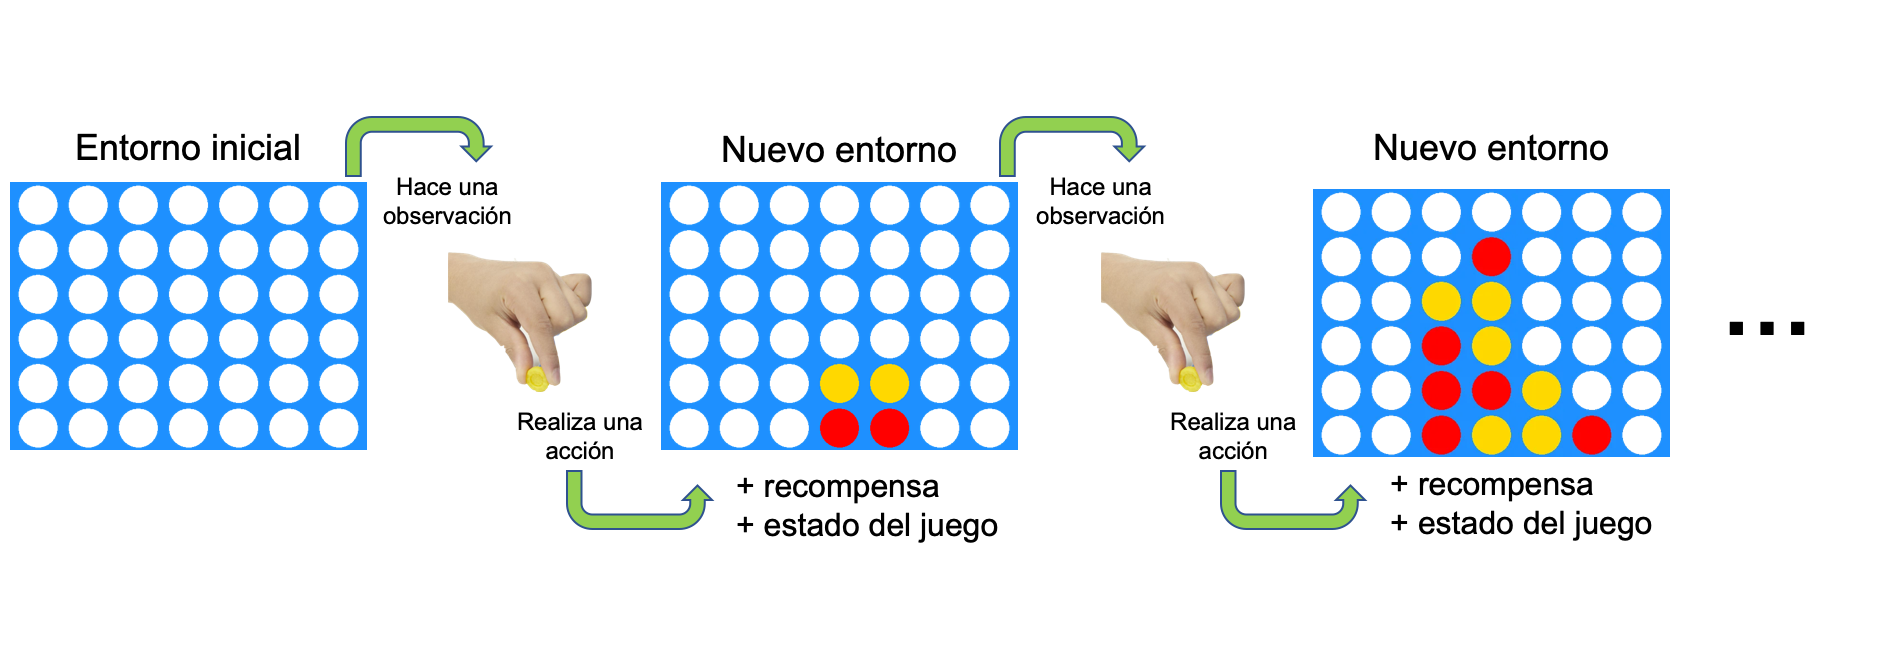

In [19]:
Image(filename='./imagenes/RL_conecta_4.png', width=800)

En un entorno Gym esto se expresa generalmente como:

```python
obs_0 = env.reset()         #Entorno inicial, primera observación
ac_0 = agent.act(obs_0)          #El agente hace una primera acción
obs_1, rew_0, done_0, info_0 = env.step(ac_0)   #El entorno regresa una observation,
                                                #una recompensa y un boleano
                                                #que indica si el juego ha terminado
ac_1 = agent.act(obs_1)
obs_2, rew_1, done_1, info_1 = env.step(ac_1)
...                                             #Y así sucesivamente
ac_n = agent.act(obs_n)
obs_n+1, rew_n, done_n, info_2 = env.step(ac_n)
done_n == True => fin


In [20]:
!pip install gym
import gym
from gym import spaces

class ConnectFourGym(gym.Env):                            #Definimos el entorno de juego usando la interfaz Gym de OpenIA

    def __init__(self, agent2 = "random"):

        ks_env = make("connectx", debug=True)             #Creamos el entorno de juego
        self.env = ks_env.train([None, agent2])           #Establecemos nuestro agente de entrenamiento
        self.rows = ks_env.configuration.rows             #Determinamos las filas
        self.columns = ks_env.configuration.columns       #Determinamos las columnas

        self.action_space = spaces.Discrete(self.columns)                                                            #Delimitamos el número de acciones
        self.observation_space = spaces.Box(low = 0, high = 2, shape = (1, self.rows, self.columns), dtype = int)    #Delimitamos el espacio de observación
        self.reward_range = (-10, 1)                         #Rango mínimo y máximo de las recompensas

        self.spec = None                  #Especificaciones para hacer compatible
        self.metadata = None              #al entorno con StableBaselines

    def reset(self):        #Restablecemos el tablero
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(1, self.rows, self.columns)

    def change_reward(self, old_reward, done):        #Fijamos las recompensas
        if old_reward == 1:        #+1 si  agente ganó el juego
            return 1
        elif done:                 #-1 si el oponente ganó el juego
            return -1
        else:                      #+1/42 en cualquier otro movimiento
            return 1/(self.rows*self.columns)

    def step(self, action):

        is_valid = (self.obs['board'][int(action)] == 0)        #Verificamos que el movimiento del agente sea válido
        if is_valid:            #El agente hace su movimiento
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else:                   #El juego termina y el agente es penalizado con -10
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(1, self.rows, self.columns), reward, done, _

In [21]:
env = ConnectFourGym(agent2 = "random")       #Creamos el entorno

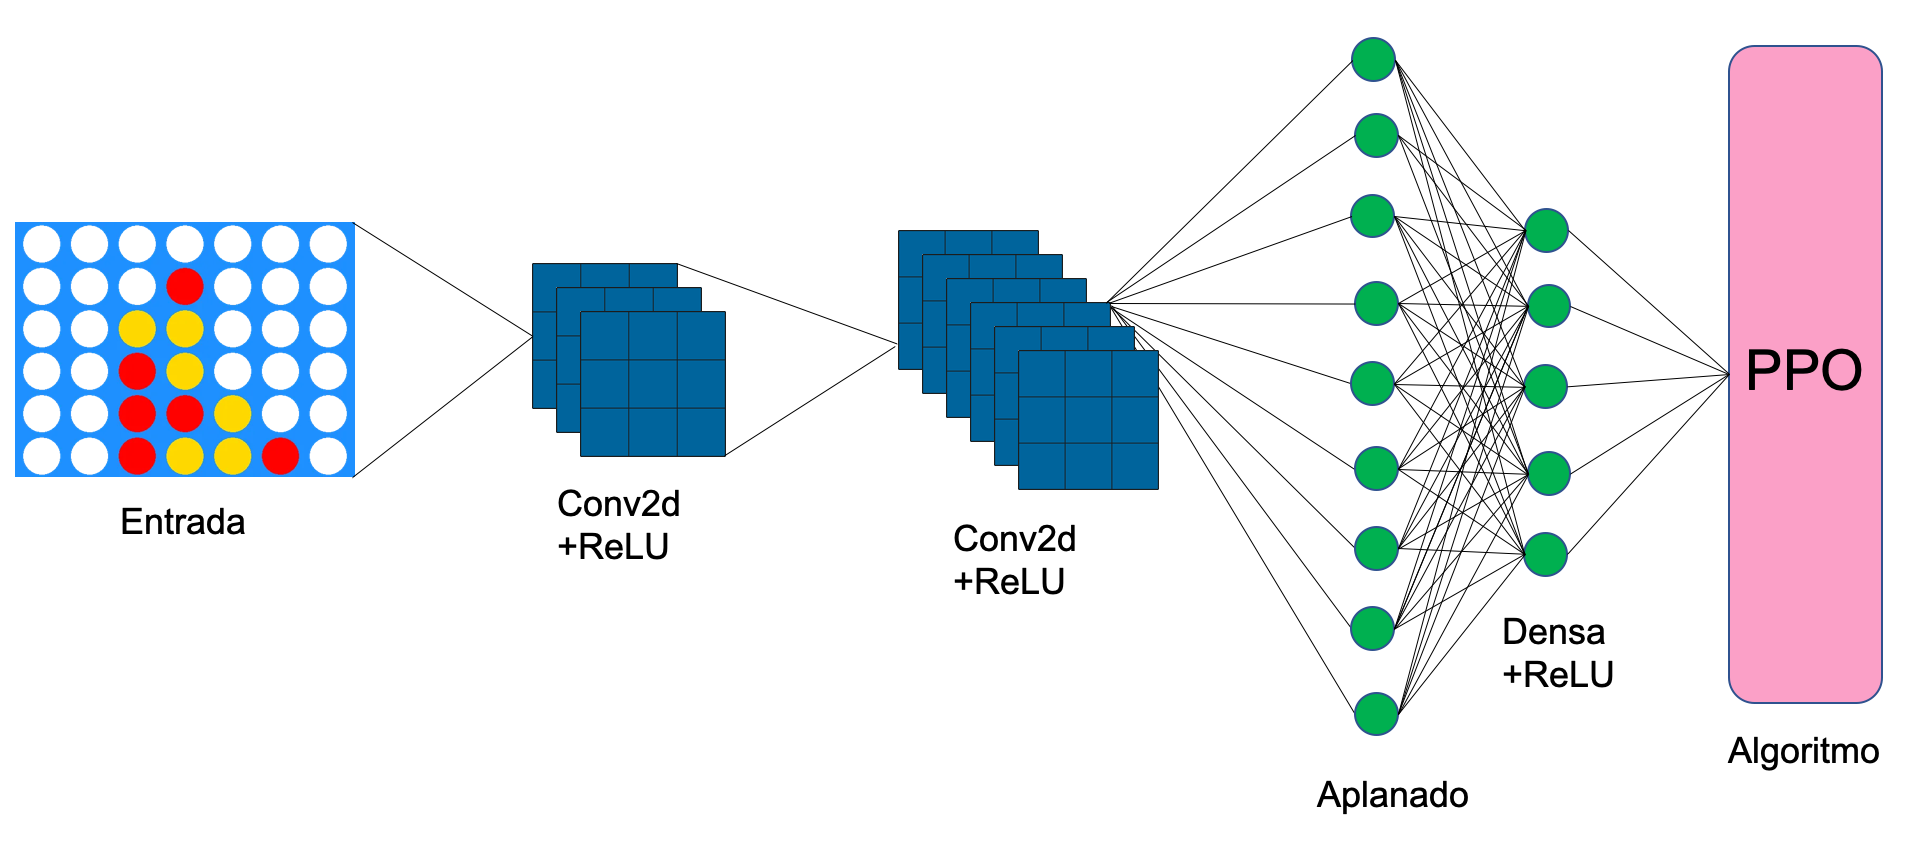

In [22]:
Image(filename='./imagenes/Red_conecta_4.png', width=800)

El objetivo de PPO es que el agente aprenda una política $π_{\theta}(a∣s)$ que maximice las recompensas acumuladas a lo largo del tiempo.

Es un algoritmo actor-critico, es decir, dado un estado del entorno:

- Actor: Decide que acción tomar de acuerdo a una probabilidad
- Crítico: Estima la recompensa esperada a futuro

En lineas generales:

1. El agente interactua con el entorno usando su política $π(a∣s)$ y obtiene información.

2. Calcula una función de ventaja $A(s,a)$, que estima si es mejor tomar una acción $a$ en un estado $s$ en comparación con el promedio del resto de acciones.

3. Maximiza la recompensa esperada mientras limita cambios drásticos en la política, usando una función de pérdida con un término de recorte o "clipping",

$$L^{CLIP}(θ)=\mathbb{E}_{t}[\text{min}(r_{t}(θ)A_{t},\text{clip}(r_{t}(θ),1−ϵ,1+ϵ)A_{t})],$$

donde $r_{t}(θ)=\frac{π_{θ}(a_{t}∣s_{t})}{π_{θ\text{old}}(a_{t}∣s_{t})}$
es el ratio entre la nueva y la vieja política.

4. Actualiza la parte crítica minimizando el error en la estimación de la recompensa esperada.

In [23]:
import torch as th
import torch.nn as nn

!pip install "stable-baselines3"
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCNN(BaseFeaturesExtractor):          #Definimos la CNN usando la interfaz BaseFeaturesExtractor de Stable-Baselines3

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 128):

        super().__init__(observation_space, features_dim)         #Introducimos el espacio de observación y las características a extraer

        n_input_channels = observation_space.shape[0]             #Introducimos el canal nuestro tablero, recordemos que (canal, filas, columnas)

        self.cnn = nn.Sequential(                                                          #Establecemos una CNN de dos capas
            nn.Conv2d(n_input_channels, 32, kernel_size = 3, stride = 1, padding = 0),     #Primera capa convolucional
            nn.ReLU(),                                                                     #Función de activación
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 0),                   #Segunda capa convolucional
            nn.ReLU(),                                                                     #Función de activación
            nn.Flatten())                                                                  #Aplanamos la salida en un vector unidimensional

        with th.no_grad():                            #Calculamos la dimensión de salida de la CNN
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())         #Establecemos una red densamente conectada

    def forward(self, observations: th.Tensor) -> th.Tensor:         #Procesamos las observaciones a través de la red completa
        return self.linear(self.cnn(observations))

policy_kwargs = dict(features_extractor_class = CustomCNN)           #Indicamos como procesar las características obtenidas en el modelo

model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose = 1)           #Usamos el modelo PPO para entrenar a nuestro agente

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [24]:
model.learn(total_timesteps = 20000)         #Entrenamos al agente

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.6     |
|    ep_rew_mean     | -1.35    |
| time/              |          |
|    fps             | 100      |
|    iterations      | 1        |
|    time_elapsed    | 20       |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -2.21      |
| time/                   |            |
|    fps                  | 91         |
|    iterations           | 2          |
|    time_elapsed         | 44         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00841799 |
|    clip_fraction        | 0.0723     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.94      |
|    explained_variance   | -0.0069    |
|    learning_rate        | 0.0003     |
|   

Definimos a nuestro agente entrenado

In [25]:
def trained_agent(obs, config):

    col, _ = model.predict(np.array(obs['board']).reshape(1, 6, 7))         #Usamos el mejor modelo para escoger una columna

    is_valid = (obs['board'][int(col)] == 0)       #Verificamos que la columna seleccionada sea válida

    if is_valid:
        return int(col)
    else:                       #Si no es valida se escoge una al azar
        return choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

Probamos a nuestro agente entrenado contra el agente "random" en un juego

In [26]:
env = make("connectx")
env.run([trained_agent, "random"])
env.render(mode="ipython", width = 500, height = 450)

Evaluamos su desempeño a lo largo de una serie de juegos contra el agente "random"

In [30]:
get_win_percentages(agent1 = trained_agent, agent2 = "random")

Porcentaje de victorias del agente 1: 71.0%
Porcentaje de victorias del agente 2: 29.0%
Número de jugadas invalidas del 1: 0
Número de jugadas invalidas del 2: 0
